In [254]:
import simpy
import random 
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [124]:
RANDOM_SEED = 43
TICKETS = 50  # Number of tickets per movie
SIM_TIME = 120  # Simulate until

THREADS_PER_CORE = 25
CORES = 4
RESPONSE_TIME = random.randint(3, 9)
MAX_QUEUE_LEN = 10000

In [129]:
# To Do
# counter: downtime
# counter for 5 minutes, ADD 2,000 capacity to queue every minute, but remove any capacity over 10,000 
# counter: hour of day (resets every 1440)
# counter: day of week (resets every 10080)

# check: day of week (return fixed number requests)
# check: time of day (apply multiplier)

# Question how to handle time? timeout vs processes
# Does this work: (1 / avg_req_min)
# How to reset Resource?
# Fulton: look at demand over time (continuous). You can model without a queue. Finite 
# set of demanmd. balance for demand vs supply.
# this is a tank model, overflows 

# Add requests per minute to the queue
# Wait response time (will have randomness)
# When queue (Resource) depletes from 10,000 within 5 mins, increment 10 mins downtime

# add randomness to number request count
# add randomness to response time / number of requests server can handle per minute (i.e. request_queue -= 2000)

In [130]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience

In [ ]:
# To Do #
# create more variables in place of hardcoded values
# clean up code

# check if logic for capacity makes sense, it's supposed to be 10,000 over 5 mins, 10,000 total
# add colors for outages
# calculate summary statistics (total downtime, perc uptime, total outages)
# flow diagram (whimsical)

# Nice to haves #
# replace weekday vs weekend with mon, tue, wed, thur
# exponetial decay for PR and bot requests

# Completed #
# capture events in dataframe
# plot dataframe
# marketing campaigns, based on week
# counter for bot attack, make it last for 5 minutes

In [393]:
def get_time_of_day(time_of_day_counter):
    # 8:01pm until 6am
    if time_of_day_counter > 1200 or time_of_day_counter < 301:
        time_of_day = ("Night", .9)
    # 6:01am until 12pm
    elif time_of_day_counter > 300 and time_of_day_counter < 721:
        time_of_day = ("Morning", 1)
    # 12:01pm until 8pm
    elif time_of_day_counter > 720 and time_of_day_counter < 1201:
        time_of_day = ("Afternoon", 1.3)
    return time_of_day

def get_day_of_week(day_of_week_counter):
    if day_of_week_counter < 7201:
        day_of_week = ("Weekday", 1)
    elif day_of_week_counter > 7200:
        day_of_week = ("Weekend!", 0.6)
    return day_of_week

def get_marketing_campaign(day_of_week_counter, time_of_day):
    # Monday - Wednesday
    if day_of_week_counter < 4320 and time_of_day == "Afternoon":
        mk_requests = 100
    else:
        mk_requests = 0
    return mk_requests

def get_attack_of_the_bots():
    if np.random.binomial(1, 0.05):
        bot_requests = 800
    else:
        bot_requests = 0
    return bot_requests

def get_national_press():
    if np.random.binomial(1, 0.02):
        press_requests = 1200
    else:
        press_requests = 0
    return press_requests

def server_sim(sim_min, requests_per_min):
    downtime_counter = 0
    request_queue = 0
    time_of_day_counter = 1
    day_of_week_counter = 1
    pr_counter = 0
    bot_counter = 0
    i = 1
    df_sim = pd.DataFrame(columns = ['Minute', 'Req_Queue', 'Req_Mod', 'Time_of_Day', 
                                     'Day_of_Week', 'Req_MK', 'Req_Bots', 'Req_PR', 
                                     'Req_Orig', 'Downtime', 'Downtime_Min'])
    while i <= sim_min:
        if request_queue < 0:
            request_queue = 0
                
        time_of_day = get_time_of_day(time_of_day_counter)
        day_of_week = get_day_of_week(day_of_week_counter)
        mk_reqs = get_marketing_campaign(day_of_week_counter, time_of_day[0])
        bot_reqs = get_attack_of_the_bots()
        pr_reqs = get_national_press()

        if pr_reqs > 0:
            pr_counter = 10
        
        if pr_counter > 0:
            pr_reqs = 1000
            
        if bot_reqs > 0:
            bot_counter = 5
        
        if bot_counter > 0:
            bot_reqs = 1000
                
        avg_req_min = np.random.normal(requests_per_min, 500, 1)[0]
        avg_req_min_mod = avg_req_min * time_of_day[1] * day_of_week[1] + mk_reqs + bot_reqs + pr_reqs
        #print("Modifying: ", avg_req_min, "Time of day: ", time_of_day[1], "Day: ", 
        #      day_of_week[1], "Bot requests: ", bot_requests, "PR: ", press_requests, "New:", avg_req_min_mod)
            
        request_queue += avg_req_min_mod
        #print("Minute: ", i, "Request queue size: ", request_queue, "Time of day: ", time_of_day[1])
                
        overcapacity = 10 if request_queue > 10000 else 0
            
        df_sim = df_sim.append({'Minute' : i, 'Req_Queue' : request_queue, 'Req_Mod' : avg_req_min_mod,
                                'Time_of_Day' : time_of_day[0], 'Day_of_Week' : day_of_week[1], 
                                'Req_MK' : mk_reqs, 'Req_Bots' : bot_reqs, 'Req_PR' : pr_reqs, 
                                'Req_Orig' : avg_req_min, 'Downtime' : (request_queue > 10000),
                                'Downtime_Min' : overcapacity}, ignore_index = True)
         
        if time_of_day_counter == 1440:
            time_of_day_counter = 0
                       
        if day_of_week_counter == 7200:
            day_of_week_counter = 0
            
        if request_queue > 10000:
            print("DOWNTIME!")
            downtime_counter += 10
            i += 10
            time_of_day_counter += 10
            day_of_week_counter += 10
            request_queue = 0
            pr_counter = 0
            bot_counter = 0
            continue
               
        request_queue -= 2000
        
        pr_counter -=1
        bot_counter -=1
        time_of_day_counter +=1
        day_of_week_counter +=1
        i += 1
        
    return downtime_counter, df_sim

In [394]:
#print(server_sim(310, 2000))
dt_count, df_sim = server_sim(1440, 1000)

DOWNTIME!
DOWNTIME!
DOWNTIME!
DOWNTIME!


In [395]:
dt_count

40

In [396]:
df_sim.tail(50)

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
1354,1391,947.607072,947.607072,Night,1,0,0,0,1052.896747,False,0
1355,1392,1855.993250,1855.993250,Night,1,0,0,1000,951.103611,False,0
1356,1393,2146.110451,2146.110451,Night,1,0,0,1000,1273.456057,False,0
1357,1394,2011.372589,1865.262138,Night,1,0,0,1000,961.402375,False,0
1358,1395,1920.383324,1909.010735,Night,1,0,0,1000,1010.011928,False,0
1359,1396,2516.829761,2516.829761,Night,1,0,0,1000,1685.366401,False,0
1360,1397,2373.463125,1856.633364,Night,1,0,0,1000,951.814849,False,0
1361,1398,2589.437114,2215.973989,Night,1,0,0,1000,1351.082210,False,0
1362,1399,3709.149628,3119.712514,Night,1,0,0,1000,2355.236127,False,0
1363,1400,3500.644024,1791.494397,Night,1,0,0,1000,879.438218,False,0


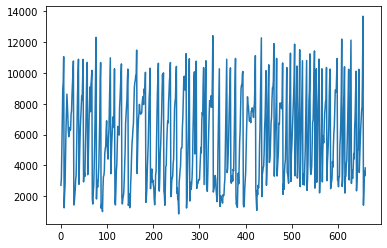

In [380]:
plt.plot(df_sim['Req_Queue'])

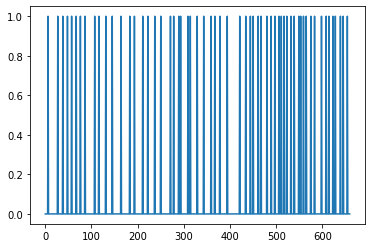

In [381]:
plt.plot(df_sim['Downtime'])

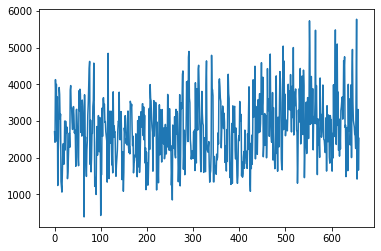

In [382]:
plt.plot(df_sim['Req_Mod'])